<a href="https://colab.research.google.com/github/spe301/Clustering-Automobile-Customers/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Potosnail==0.0.9

In [2]:
from potosnail import *
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

ml = MachineLearning()
dh = DataHelper()
ev = Evaluater()
st = Stats()

def GetTopN(df, var, n):
    dict(df[var].value_counts())
    X = list({v: k for k, v in dict(df[var].value_counts()).items()}.values())[:n]
    y = list({v: k for k, v in dict(df[var].value_counts()).items()}.keys())[:n]
    sns.barplot(X, y);
    plt.show()

def BinaryBarGraph(df, opt1, opt2, var):
    yes = len(df.loc[df[var] == opt1])/len(df)
    no = 1 - yes
    X = [opt1, opt2]
    y = [yes, no]
    sns.barplot(X, y);
    plt.show()
    return 'The sample is {}% {} and {}% {}'.format(int(round(yes*100)), opt1, int(round(no*100)), opt2)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
d1 = pd.read_csv('https://raw.githubusercontent.com/spe301/Clustering-Automobile-Customers/main/Train.csv')
d2 = pd.read_csv('https://raw.githubusercontent.com/spe301/Clustering-Automobile-Customers/main/Test.csv')
df = pd.concat([d1, d2]).drop(['ID', 'Var_1', 'Segmentation'], axis='columns').reset_index()

# How I'm going to go about this...

Scrub: clean this data so it can be interpreted by a model

Explore: draw insights and visualize the data

Model: build a Clustering model to segment the customers into 5 distinct segments, one for each product

Interpret: analyze the clusters to match each cluster with the appropriate product.

# Scrub
## Filling in NaN values

In [4]:
df['Ever_Married'] = df['Ever_Married'].fillna('No')
df['Graduated'] = df['Graduated'].fillna('No')
df['Profession'] = df['Profession'].fillna('None')
df['Work_Experience'] = df['Work_Experience'].fillna(int(np.mean(df['Work_Experience'])))
df['Family_Size'] = df['Family_Size'].fillna(int(round(np.mean(df['Family_Size']))))
df.isna().sum()

index              0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
dtype: int64

In [5]:
df = df.drop(['index'], axis='columns')
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,22,No,Healthcare,1.0,Low,4.0
1,Female,Yes,38,Yes,Engineer,2.0,Average,3.0
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,Female,Yes,40,Yes,Entertainment,2.0,High,6.0


Converting gender, married, and graduated to 0's and 1's. However, I will also keep the original columns for Analysis purposes.

In [6]:
lst = ['Gender', 'Ever_Married', 'Graduated']
keepers = df[lst]

In [7]:
df2 = pd.concat([dh.Binarize(df, lst), keepers], axis='columns')
df2.columns = list(df2.columns)[:-3] + ['Gender_str', 'Married_str', 'Grad_str']
df2.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Gender_str,Married_str,Grad_str
0,1,1,22,1,Healthcare,1.0,Low,4.0,Male,No,No
1,0,0,38,0,Engineer,2.0,Average,3.0,Female,Yes,Yes
2,0,0,67,0,Engineer,1.0,Low,1.0,Female,Yes,Yes
3,1,0,67,0,Lawyer,0.0,High,2.0,Male,Yes,Yes
4,0,0,40,0,Entertainment,2.0,High,6.0,Female,Yes,Yes


One Hot Encoding Profession, again I will hold onto the original column for Analysis purposes.

In [8]:
df3 = pd.concat([df2, dh.OHE(df2['Profession'])], axis='columns')
df3.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Gender_str,Married_str,Grad_str,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,None
0,1,1,22,1,Healthcare,1.0,Low,4.0,Male,No,No,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0,38,0,Engineer,2.0,Average,3.0,Female,Yes,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,67,0,Engineer,1.0,Low,1.0,Female,Yes,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,67,0,Lawyer,0.0,High,2.0,Male,Yes,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0,40,0,Entertainment,2.0,High,6.0,Female,Yes,Yes,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Converting Spending Score to numerical data, this time I will drop the original column altogether bceause the data is rankable. (ie. 1 can represent low, 2 average, and so on)

In [9]:
ss = df3['Spending_Score']
scores = []
for i in range(len(ss)):
    if ss[i] == 'Low':
        scores.append(1)
    if ss[i] == 'Average':
        scores.append(2)
    if ss[i] == 'High':
        scores.append(3)
        
df3['Spending_Score'] = scores

In [10]:
df3.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Gender_str,Married_str,Grad_str,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,None
0,1,1,22,1,Healthcare,1.0,1,4.0,Male,No,No,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0,38,0,Engineer,2.0,2,3.0,Female,Yes,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,67,0,Engineer,1.0,1,1.0,Female,Yes,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,67,0,Lawyer,0.0,3,2.0,Male,Yes,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0,40,0,Entertainment,2.0,3,6.0,Female,Yes,Yes,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA questions

1. How is age distributed among different Spending Scores?
2. is the difference in spending score for married and unmarried customers statistically signifigant?
3. What are the most common professions among each spending score and how do they differ?

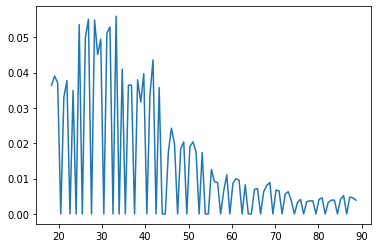

In [11]:
st.PDF(df3.loc[df3['Spending_Score'] == 1]['Age'])

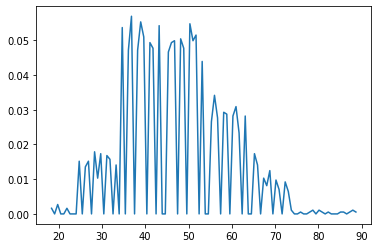

In [12]:
st.PDF(df3.loc[df3['Spending_Score'] == 2]['Age'])

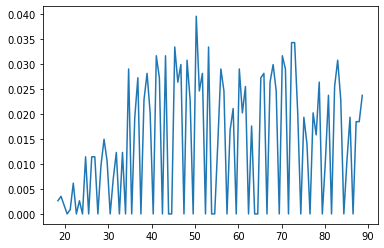

In [13]:
st.PDF(df3.loc[df3['Spending_Score'] == 3]['Age'])

Conclusion: Spending Scores tend to increase as age increases. Almost all customers with 'low' spending scores are under 50, and the distribution really dips off after 40.

Reccomendation: avoid marketing more expensive vehicles to people under 35-40.

In [57]:
n = 100
married_sample = df3.loc[df3['Married_str']=='Yes'].sample(n)['Spending_Score']
unmarried_sample = df3.loc[df3['Married_str']=='No'].sample(n)['Spending_Score']

In [58]:
married_sample

6325     2
5852     3
8311     2
6757     3
10418    2
        ..
3965     2
3273     2
1324     1
5301     2
9934     3
Name: Spending_Score, Length: 100, dtype: int64

In [61]:
from scipy import stats
stats.ttest_ind(unmarried_sample, married_sample)

Ttest_indResult(statistic=-11.466761001209594, pvalue=1.1304228189160947e-23)

H0 = there's no correlation between spending and being married

H1 = married people tend to spend less because they often have to agree on the purchase with their spouse.

We reject the null hypothesis, however it actually turns out that unmarried customers have lower spending scores on average. most likley because only one person will pay for the car.

Reccomendation: prioritize advertising towards married people in general as they're likley to spend more.

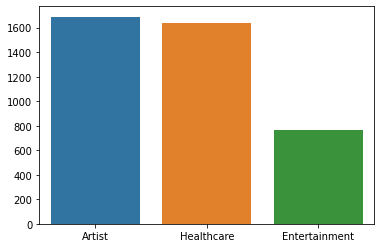

None
Where Spending Score = 1


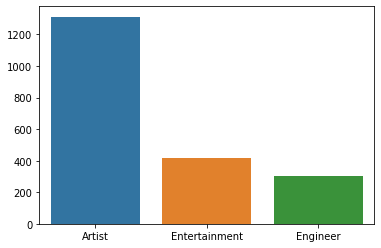

None
Where Spending Score = 2


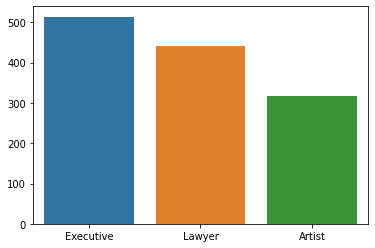

None
Where Spending Score = 3

31% of the customers in this dataset are artists


In [70]:
for i in range(1, 4):
  data = df3.loc[df3['Spending_Score']==i]
  print(GetTopN(data, 'Profession', 3))
  print('Where Spending Score = {}'.format(i))

print()
print('{}% of the customers in this dataset are artists'.format(round(len(df3.loc[df['Profession']=='Artist'])/len(df3)*100)))

Conclusion: Healthcare workers tend to spend the least, while lawers and executives tend to spend the most.

Reccomendation: Even without any clustering, we can infer that it's best that our Sedan be marketed to healthcare workers while the sport's car should be catered to execs and lawers. These findings also suggest that the pickup truck may not do well, but there is no evidence.

# Modeling

I use K-Means Clustering to categorize our customers into 5 distinct groups, one for each product. I will then use PCA to reduce the data to 2 dimensions so we can acually visualize it, but keep in mind that this second model won't be very effective for classification and will only be used for visualization.

In [92]:
df4 = df3.drop(['Profession', 'Gender_str', 'Married_str', 'Grad_str'], axis='columns') #dropping string (text) values, they have already been converted.

def ClusterIt(data, clusters):
    k = KMeans(n_clusters=clusters).fit(data)
    pred = k.predict(data)
    centers = k.cluster_centers_
    X2 = pd.DataFrame(data)
    y = pd.DataFrame(pred)
    y.columns = ['cluster']
    results = pd.concat([X2, y], axis='columns')
    return results

clustered = ClusterIt(df4, 5)
##adding string values back in for analysis
clustered['Profession'] = df3['Profession']
clustered['Gender_str'] = df3['Gender_str']
clustered['Married'] = df3['Married_str']
clustered.head()

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,None,cluster,Profession,Gender_str,Married
0,1,1,22,1,1.0,1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,Healthcare,Male,No
1,0,0,38,0,2.0,2,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Engineer,Female,Yes
2,0,0,67,0,1.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Engineer,Female,Yes
3,1,0,67,0,0.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,Lawyer,Male,Yes
4,0,0,40,0,2.0,3,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Entertainment,Female,Yes


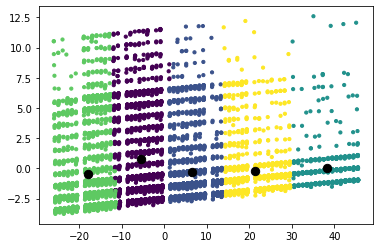

,0,1,cluster
0,-21.488977,-2.371974,3
1,-5.471227,-0.739140,0
2,23.555523,-0.631179,4
3,23.613680,-1.705876,4
4,-3.529076,-0.874271,0
...,...,...,...
10690,-14.781350,5.836852,3
10691,-8.418693,-1.702247,0
10692,9.498395,-0.168781,1
10693,3.524425,-1.580456,1


In [93]:
ml.Cluster2D(df4, 5)

# Analyzing the clusters

For each cluster I will get the distribution of Age, married to unmarried breakdown, gender breakdown, most common professions, average family size, and average Spending Score.

In [94]:
c1 = clustered.loc[clustered['cluster'] == 0]
c2 = clustered.loc[clustered['cluster'] == 1]
c3 = clustered.loc[clustered['cluster'] == 2]
c4 = clustered.loc[clustered['cluster'] == 3]
c5 = clustered.loc[clustered['cluster'] == 4]

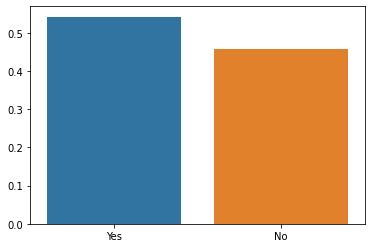

The sample is 54% Yes and 46% No


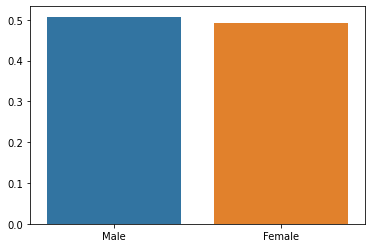

The sample is 51% Male and 49% Female


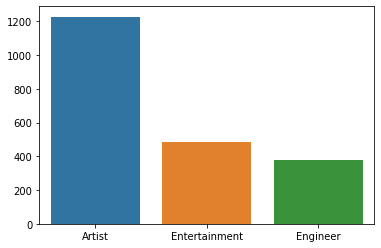

None
The average customer has a family of 2.647113022113022
The average customer has a spending score of 1.461916461916462
None


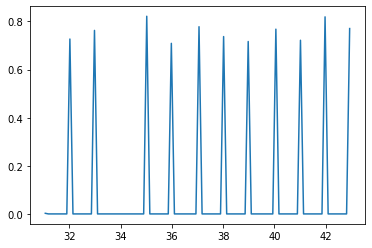

In [99]:
def BinaryBarGraph(df, opt1, opt2, var):
    yes = len(df.loc[df[var] == opt1])/len(df)
    no = 1 - yes
    X = [opt1, opt2]
    y = [yes, no]
    sns.barplot(X, y);
    plt.show()
    return 'The sample is {}% {} and {}% {}'.format(int(round(yes*100)), opt1, int(round(no*100)), opt2)

def AnalyzeCluster(cluster, var1, var2, var3, var4, var5, var6, opt1, opt2, opt3, opt4, n):
  print(BinaryBarGraph(cluster, opt1, opt2, var2))
  print(BinaryBarGraph(cluster, opt3, opt4, var3))
  print(GetTopN(cluster, var4, n))
  print('The average customer has a family of {}'.format(np.mean(cluster[var5])))
  print('The average customer has a spending score of {}'.format(np.mean(cluster[var6])))

AnalyzeCluster(c1, 'Age', 'Married', 'Gender_str', 'Profession', 'Family_Size', 'Spending_Score', 'Yes', 'No', 'Male', 'Female', 3)
print(st.PDF(c1['Age']))

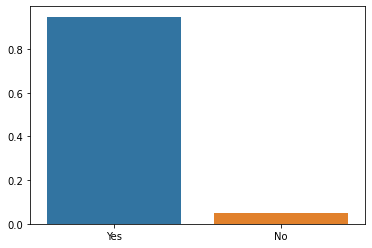

The sample is 95% Yes and 5% No


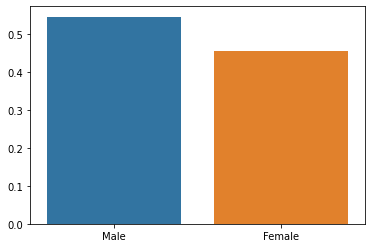

The sample is 54% Male and 46% Female


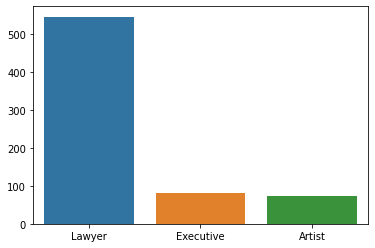

None
The average customer has a family of 1.8981481481481481
The average customer has a spending score of 2.1031746031746033
None


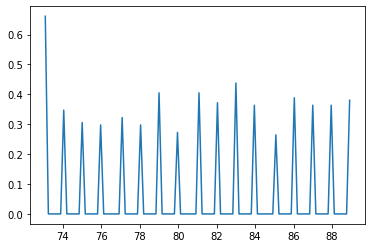

In [101]:
AnalyzeCluster(c2, 'Age', 'Married', 'Gender_str', 'Profession', 'Family_Size', 'Spending_Score', 'Yes', 'No', 'Male', 'Female', 3)
print(st.PDF(c2['Age']))

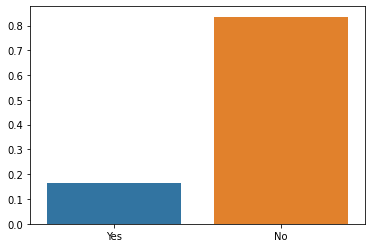

The sample is 16% Yes and 84% No


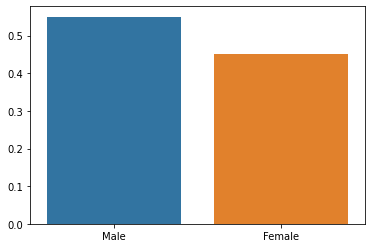

The sample is 55% Male and 45% Female


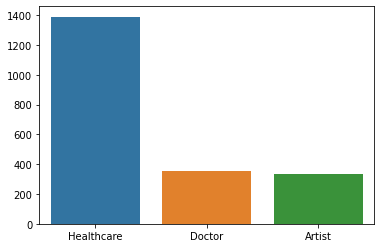

None
The average customer has a family of 3.4818670248488917
The average customer has a spending score of 1.141370047011417
None


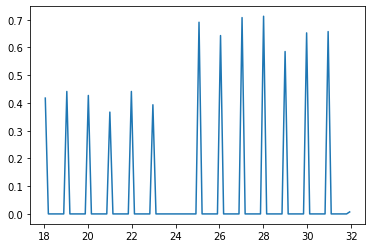

In [102]:
AnalyzeCluster(c3, 'Age', 'Married', 'Gender_str', 'Profession', 'Family_Size', 'Spending_Score', 'Yes', 'No', 'Male', 'Female', 3)
print(st.PDF(c3['Age']))

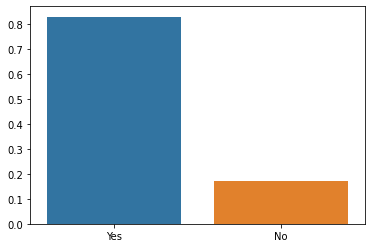

The sample is 83% Yes and 17% No


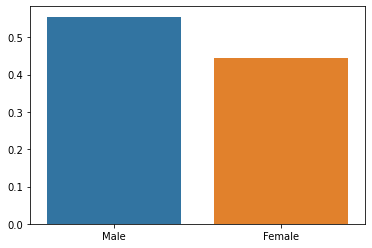

The sample is 56% Male and 44% Female


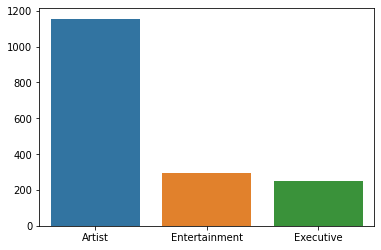

None
The average customer has a family of 2.834342560553633
The average customer has a spending score of 1.7560553633217992
None


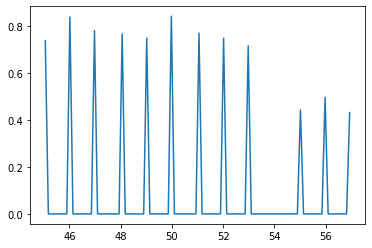

In [103]:
AnalyzeCluster(c4, 'Age', 'Married', 'Gender_str', 'Profession', 'Family_Size', 'Spending_Score', 'Yes', 'No', 'Male', 'Female', 3)
print(st.PDF(c4['Age']))

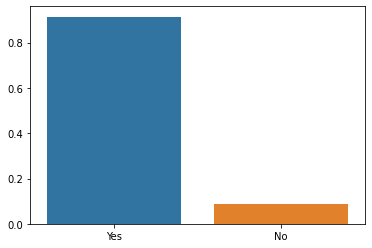

The sample is 91% Yes and 9% No


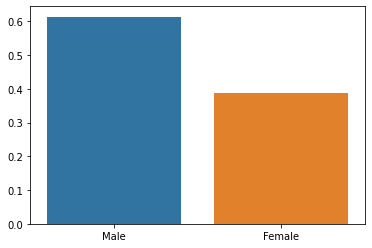

The sample is 61% Male and 39% Female


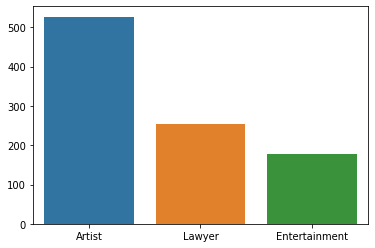

None
The average customer has a family of 2.52045944005743
The average customer has a spending score of 1.9303661162957646
None


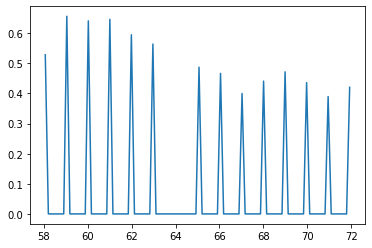

In [104]:
AnalyzeCluster(c5, 'Age', 'Married', 'Gender_str', 'Profession', 'Family_Size', 'Spending_Score', 'Yes', 'No', 'Male', 'Female', 3)
print(st.PDF(c5['Age']))

Infrences...

Cluster1 = Station Wagon

Cluster2 = Storts Car

Cluster3 = Sedan

Cluster4 = Compact SUV

Cluster5 = Pickup Truck

Additional Reccomendation: The pickup Truck seems the least likley to be a hit but cluster 5 seems the most likley to buy it. if the ads convert poorly, the main focus should shift to advertising the Compact SUV or Sports Car, and we should decrease Truck Production as well.